### Importacion de librerias 

In [39]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns


### Extraer los datos

In [40]:
df = pd.read_csv("../data/clean_dataset.csv")
df

,condition,price,automatic_relist,initial_quantity,sold_quantity,available_quantity,pixels,max_pixels,free_shipping,local_pick_up,...,state_seller_state_Neuquén,state_seller_state_Río Negro,state_seller_state_Salta,state_seller_state_San Juan,state_seller_state_San Luis,state_seller_state_Santa Cruz,state_seller_state_Santa Fe,state_seller_state_Santiago del Estero,state_seller_state_Tierra del Fuego,state_seller_state_Tucumán
0,1,80.0,0,1,0,1,187500.0,1080000.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,2650.0,0,1,0,1,166666.0,605787.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,60.0,0,1,0,1,187500.0,1080000.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,580.0,0,1,0,1,186543.0,186543.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,30.0,0,1,0,1,187500.0,307200.0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97176,0,30.0,0,1,0,1,187500.0,1080000.0,0,1,...,0,0,0,0,0,0,0,0,0,0
97177,1,239.0,0,5,0,5,187500.0,1080000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
97178,0,600.0,0,1,0,1,187500.0,1080000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
97179,0,50.0,0,1,0,1,193500.0,1117200.0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Entrenamiento del modelo

In [41]:
X = df.drop(columns=['condition'])
y = df['condition']


num_cols = X.select_dtypes(include=['int64', 'float64']).columns


scaler = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')  

X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}


results = []

for name, estimator in models.items():
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    results.append({
        'Modelo': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1-Score': round(f1_score(y_test, y_pred), 4)
    })


results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\nResultados de los Modelos:")
print(results_df.to_string(index=False))



Resultados de los Modelos:
             Modelo  Accuracy  Precision  Recall  F1-Score
            XGBoost    0.8586     0.8971  0.8339    0.8643
      Random Forest    0.8527     0.8738  0.8500    0.8617
  Gradient Boosting    0.8466     0.8784  0.8311    0.8541
Logistic Regression    0.7770     0.7776  0.8222    0.7993


### Features más importantes del mejor modelo

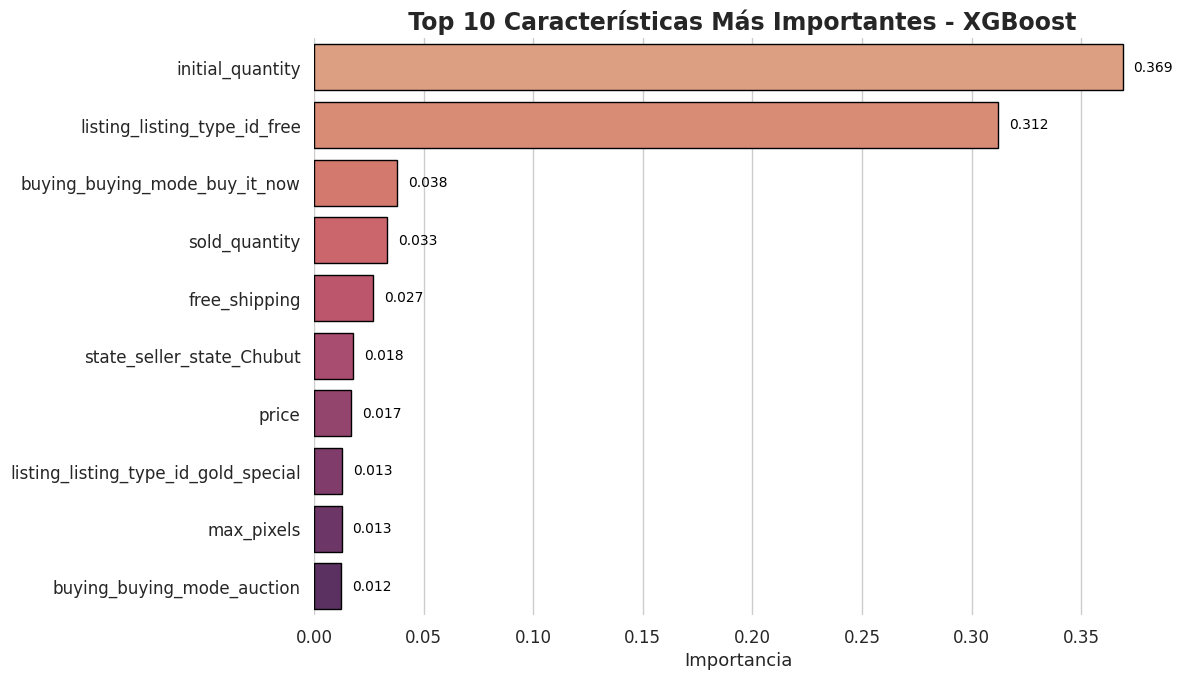

In [42]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_

feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X_scaled.shape[1])]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

sns.set(style='whitegrid', font='DejaVu Sans', font_scale=1.1)
plt.figure(figsize=(12, 7))

colors = sns.color_palette("flare", len(feature_importance_df))

barplot = sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature',
    hue='Feature',        
    palette=colors,
    dodge=False,
    legend=False,
    edgecolor='black'
)

for i, (importance, feature) in enumerate(zip(feature_importance_df['Importance'], feature_importance_df['Feature'])):
    plt.text(importance + 0.005, i, f"{importance:.3f}", va='center', fontsize=10, color='black')

plt.title(' Top 10 Características Más Importantes - XGBoost', fontsize=17, weight='bold')
plt.xlabel('Importancia', fontsize=13)
plt.ylabel('')

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
